In [1]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torch
import torch.nn as nn
from torchsummary import summary
import sys
sys.path.append("utils/")
from model import CNN

In [2]:

device_count = torch.cuda.device_count()
print("Number of available GPUs: ", device_count)

for i in range(device_count):
    print("Device {}:".format(i))
    print("Name: ", torch.cuda.get_device_name(i))
    print("Capability: ", torch.cuda.get_device_capability(i))
    print("Memory Total: ", torch.cuda.get_device_properties(i).total_memory)
    print()


Number of available GPUs:  1
Device 0:
Name:  NVIDIA GeForce RTX 2070
Capability:  (7, 5)
Memory Total:  8366915584



In [3]:
train_dir  = "../data/Train/Train/"
val_dir = "../data/Validation/Validation/"
test_dir = "../data/Test/Test/"
classes = ["Healthy","Powdery","Rust"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nclass = len(classes)
num_epochs = 150
size = 128
num_workers = 8
model_path = '../models/'

In [4]:
print(classes)
total = 0
for i in classes:
    total += len(os.listdir(train_dir+i))
print(total)

['Healthy', 'Powdery', 'Rust']
1322


In [11]:

conv = (64, 64, 64, 64,64,64)
model = CNN(size, nclass, conv)
model = model.to(device)
summary(model, (nclass, size, size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
            Conv2d-2           [-1, 64, 64, 64]          36,928
            Conv2d-3           [-1, 64, 32, 32]          36,928
            Conv2d-4           [-1, 64, 16, 16]          36,928
            Conv2d-5             [-1, 64, 8, 8]          36,928
            Conv2d-6             [-1, 64, 4, 4]          36,928
            Linear-7                  [-1, 512]         131,584
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 10]           5,130
           Linear-10                    [-1, 3]              33
Total params: 323,179
Trainable params: 323,179
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 10.67
Params size (MB): 1.23
Estimated 

In [6]:
def generator(path,transform = None):
    dataset = datasets.ImageFolder(path, transform=transform)
    data,label_list = [],[]
    for images, labels in dataset:
        data.append(images)
        label_list.append(labels)
    data = torch.stack(data)
    labels = torch.tensor(label_list)
    print(data.shape)
    print(labels.shape)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data, labels),
    batch_size=64, shuffle=True, num_workers=num_workers)
    


In [7]:
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_data_loader = generator(train_dir,transform)
val_data_loader = generator(val_dir,transform)
test_loader = generator(test_dir,transform)

torch.Size([1322, 3, 128, 128])
torch.Size([1322])
torch.Size([60, 3, 128, 128])
torch.Size([60])
torch.Size([150, 3, 128, 128])
torch.Size([150])


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
train_loss_hist = []
val_loss_hist = []
train_acc = []
val_acc = []
best_acc = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 4:
        # Calculate training accuracy
        total_train = 0
        correct_train = 0
        with torch.no_grad():
            for train_images, train_labels in train_data_loader:
                train_images = train_images.to(device)
                train_labels = train_labels.to(device)

                train_outputs = model(train_images)
                _, predicted_train = torch.max(train_outputs.data, 1)
                total_train += train_labels.size(0)
                correct_train += (predicted_train == train_labels).sum().item()
        train_loss_hist.append(loss.item())
        train_accuracy = correct_train / total_train * 100
        train_acc.append(train_accuracy)

        # Calculate validation loss and accuracy
        val_running_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_images, val_labels in val_data_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)

                val_running_loss += val_loss.item()
                _, predicted_val = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        val_loss_hist.append(val_running_loss / len(val_data_loader))
        val_accuracy = correct_val / total_val * 100
        val_acc.append(val_accuracy)
        if(val_accuracy>best_acc):
            best_acc = val_accuracy
            torch.save(model,model_path+"model.pth")

        print('[Epoch %d] Training Loss: %.3f | Training Accuracy: %.2f%% | Validation Loss: %.3f | Validation Accuracy: %.2f%%' % (epoch + 1, loss.item(), train_accuracy, val_running_loss / len(val_data_loader), val_accuracy))
        
print('Training finished.')


[Epoch 5] Training Loss: 0.540 | Training Accuracy: 66.41% | Validation Loss: 0.562 | Validation Accuracy: 65.00%
[Epoch 10] Training Loss: 0.686 | Training Accuracy: 67.93% | Validation Loss: 0.520 | Validation Accuracy: 68.33%
[Epoch 15] Training Loss: 0.693 | Training Accuracy: 63.84% | Validation Loss: 0.604 | Validation Accuracy: 61.67%
[Epoch 20] Training Loss: 0.464 | Training Accuracy: 67.85% | Validation Loss: 0.480 | Validation Accuracy: 68.33%
[Epoch 25] Training Loss: 0.554 | Training Accuracy: 66.72% | Validation Loss: 0.623 | Validation Accuracy: 65.00%
[Epoch 30] Training Loss: 0.459 | Training Accuracy: 66.72% | Validation Loss: 0.473 | Validation Accuracy: 66.67%
[Epoch 35] Training Loss: 0.410 | Training Accuracy: 69.06% | Validation Loss: 0.459 | Validation Accuracy: 70.00%
[Epoch 40] Training Loss: 0.478 | Training Accuracy: 68.08% | Validation Loss: 0.465 | Validation Accuracy: 70.00%
[Epoch 45] Training Loss: 0.589 | Training Accuracy: 67.32% | Validation Loss: 0.

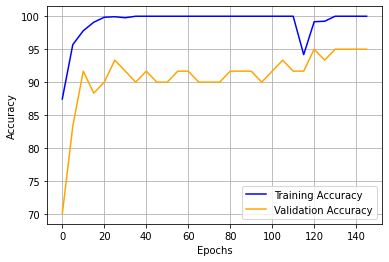

In [9]:
x_axis = np.arange(len(train_acc)) * 5
plt.plot(x_axis,train_acc, label='Training Accuracy', color='blue')
plt.plot(x_axis,val_acc, label='Validation Accuracy', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
from PIL import Image
model = torch.load(model_path+'model.pth')
def load_img(path):
    img = Image.open(path)
    transform = transforms.Compose([
        transforms.Resize((128, 128)), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    ])
    tensor_image = torch.unsqueeze(transform(img),0)
    return tensor_image.to(device)
def get_pred(img):
    pred = model(img)
    item = torch.argmax(pred)
    return classes[item]
#path = train_dir+'/Healthy/869c8acd737cc133.jpg'
#path = train_dir+'/Powdery/8a2d598f2ec436e6.jpg'
path = train_dir+'/Rust/8a9237d6a86ba167.jpg'
img = load_img(path)
print(get_pred(img))

Rust
